In [2]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import fit_library as fit
%matplotlib nbagg
%load_ext autoreload
%autoreload 2
import time
import tables
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
a=pd.read_csv("/mnt/WINDOWS_ntfs/DATOS_DAC/nominal_ch18_evt2.txt", 
              names=[0], header=None, dtype='int32')
f=np.array(np.zeros(len(a)))
f=a.values[:,0]

## Noise is in the lower band. LPF to clean the signal.

<IPython.core.display.Javascript object>


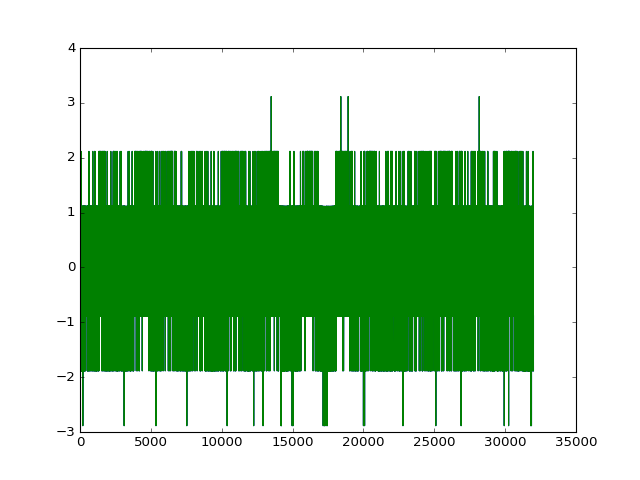

In [4]:
# Note: Use 20 MHz Bandwidth for non filtering effect

signal_in=f-np.mean(f)
f_sample = 40E6
freq_LPF = 20E6*2*np.pi
freq_LPFd = freq_LPF / (f_sample*np.pi)
b, a = signal.butter(1, freq_LPFd, 'low', analog=False)
signal_out = signal.lfilter(b,a,signal_in)


plt.figure(1)
plt.plot(signal_in)
plt.plot(signal_out)
plt.show()

In [5]:
sp = np.fft.fft(signal_out)
freq=np.fft.fftfreq(len(signal_out), d=25E-9)

## FFT after filtering

<IPython.core.display.Javascript object>


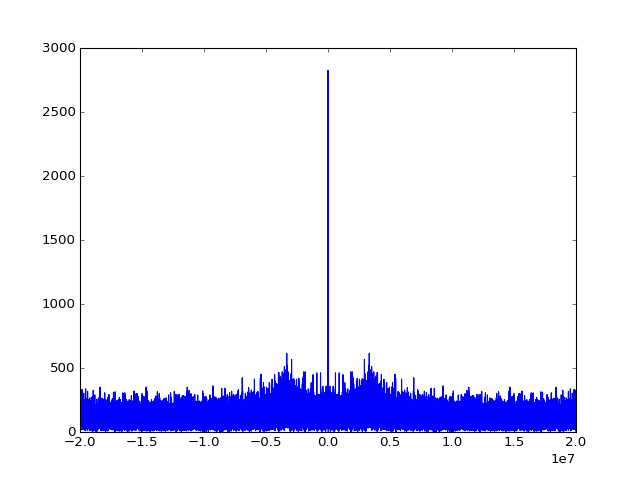

In [6]:
plt.figure(2)
plt.plot(freq, np.absolute(sp))
plt.show()

## Define frequency limits of the Senoidal noise


In [7]:
selec=(freq>10000)*(freq<25000)
whole_noise=np.sum(np.absolute(sp[0:len(sp)/2])); 
coupled_noise = np.sum(selec*np.absolute(sp));
print ("COUPLED NOISE WEIGHT (%)=", coupled_noise/whole_noise*100)

('COUPLED NOISE WEIGHT (%)=', 0.68003682053420023)


# MAU FILTERING

In [28]:
f_nomean=f-np.mean(f)

MAU_n=200.0;
MAU=np.array(np.ones(MAU_n),dtype=float)*(1/MAU_n)

MAU_out = signal.lfilter(MAU,1,f_nomean)

out_signal=f_nomean-MAU_out

(200,)


<IPython.core.display.Javascript object>


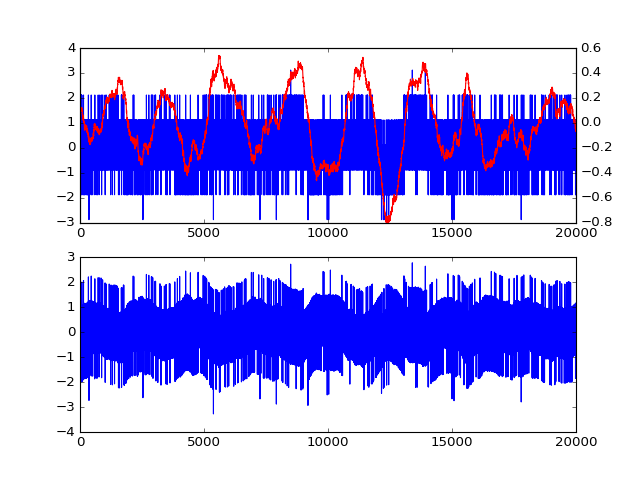

In [26]:
print(np.shape(MAU))

fig=plt.figure()
ax1 = fig.add_subplot(211)
plt.plot(f_nomean[5000:25000],'b')
ax2 = ax1.twinx()
plt.plot(MAU_out[5000:25000],'r')
plt.show()
ax3 = fig.add_subplot(212)
plt.plot(out_signal[5000:25000],'b')

### Not clean enough !!!! Also some artifacts due to the MAU are visible in the fft

In [29]:
sp_2 = np.fft.fft(out_signal[1000:30000])
freq=np.fft.fftfreq(len(out_signal[1000:30000]), d=25E-9)

<IPython.core.display.Javascript object>


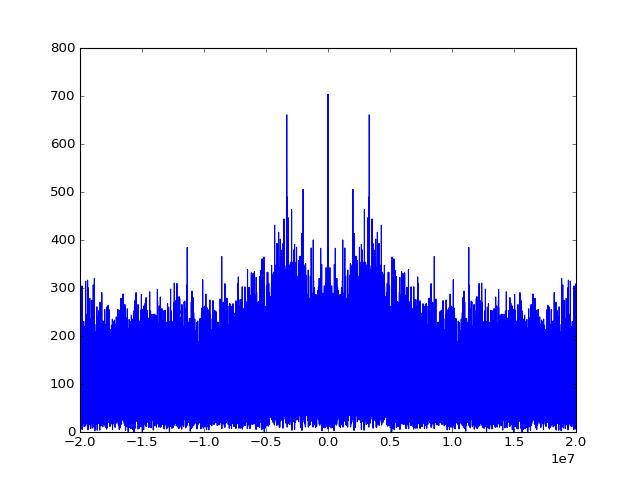

In [30]:
plt.figure()
plt.plot(freq, np.absolute(sp_2))
plt.show()

# Partial Triggering

### The fake PMT output signals are defined as pieces of the long noise signal plus a small 1 LSB signal in sample 3000 in certain PMTS

In [21]:

pmt_1=np.copy(f_nomean[1000:5000])
pmt_1[3000]=pmt_1[3000]+1.0
MAU_out1=np.copy(MAU_out[1000:5000])
pmt_2=np.copy(f_nomean[5000:9000])
pmt_2[3000]=pmt_1[3000]+0.0
MAU_out2=np.copy(MAU_out[5000:9000])
pmt_3=np.copy(f_nomean[9000:13000])
pmt_3[3000]=pmt_1[3000]+1.0
MAU_out3=np.copy(MAU_out[9000:13000])
pmt_4=np.copy(f_nomean[13000:17000])
pmt_4[3000]=pmt_1[3000]+0.0
MAU_out4=np.copy(MAU_out[13000:17000])
pmt_5=np.copy(f_nomean[17000:21000])
pmt_5[3000]=pmt_5[3000]+1.0
MAU_out5=np.copy(MAU_out[17000:21000])

<IPython.core.display.Javascript object>


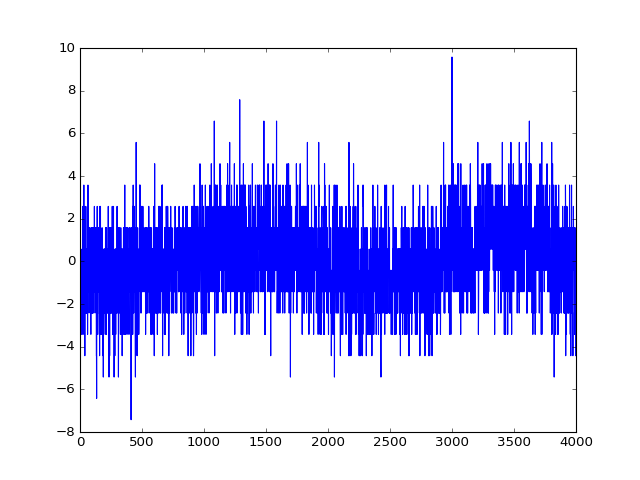

In [22]:
plt.figure()
plt.plot(pmt_1+pmt_2+pmt_3+pmt_4+pmt_5)
plt.show()

### A local threshold based on the MAU output is set to every PMT. The Addition is done on the signals above this threshold

<IPython.core.display.Javascript object>


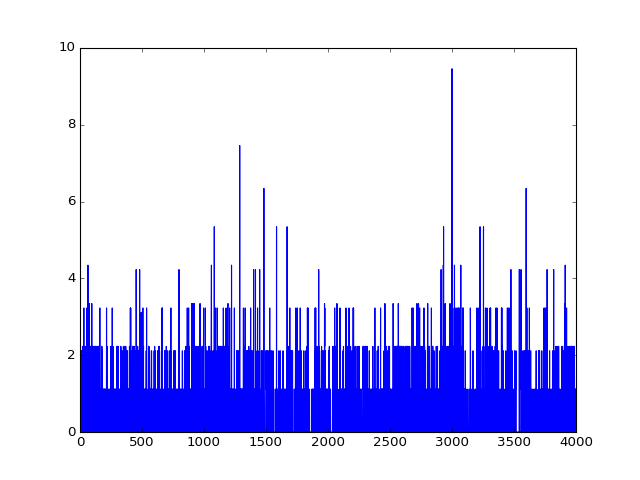

In [24]:
plt.figure()
thr=1.0
plt.plot((pmt_1>(MAU_out1+thr))*pmt_1+(pmt_2>(MAU_out2+thr))*pmt_2+
         (pmt_3>(MAU_out3+thr))*pmt_3+(pmt_4>(MAU_out4+thr))*pmt_4+
         (pmt_5>(MAU_out5+thr))*pmt_5)
        
plt.show()